In [1]:
import os

In [2]:
dataset_path = "/kaggle/input/coralreef/Bleached Corals and Healthy Corals Classification"

In [3]:
print("Dataset contents:", os.listdir(dataset_path))

Dataset contents: ['Screenshot 2023-06-03 150340.png', 'Validation', 'Training', 'Testing']


In [5]:
train_dir = os.path.join(dataset_path, "Training")  # This contains 'healthy' and 'bleached'
val_dir = os.path.join(dataset_path, "Validation")  # This contains 'healthy' and 'bleached'
test_dir = os.path.join(dataset_path, "Testing")    # If you have a test folder

Ensemble Model

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

validation_generator = validation_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

print(f"Classes found: {train_generator.class_indices}")

# Load pre-trained models
inception = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze last layers for fine-tuning
for model in [inception, vgg, resnet]:
    for layer in model.layers[-50:]:
        layer.trainable = True

# Input layer
input_layer = layers.Input(shape=(224, 224, 3))

# Feature extraction
inception_features = inception(input_layer)
vgg_features = vgg(input_layer)
resnet_features = resnet(input_layer)

# Global pooling
inception_pool = layers.GlobalAveragePooling2D()(inception_features)
vgg_pool = layers.GlobalAveragePooling2D()(vgg_features)
resnet_pool = layers.GlobalAveragePooling2D()(resnet_features)

# Concatenate features
combined_features = layers.concatenate([inception_pool, vgg_pool, resnet_pool])
combined_features = layers.BatchNormalization()(combined_features)

# Fully connected layers
x = layers.Dense(512, activation='relu')(combined_features)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

# Build model
model = models.Model(inputs=input_layer, outputs=output_layer)
optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Class Weights to handle imbalance
y_true = train_generator.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_true), y=y_true)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, 
                    class_weight=class_weights_dict, verbose=1, callbacks=[lr_scheduler])




Found 7384 images belonging to 2 classes.
Found 923 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Classes found: {'bleached_corals': 0, 'healthy_corals': 1}
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - accuracy: 0.6866 - loss: 0.6686 - val_accuracy: 0.4934 - val_loss: 1.1158 - learning_rate: 1.0000e-04
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 124s 520ms/step - accuracy: 0.8029 - loss: 0.4435 - val_accuracy: 0.4934 - val_loss: 2.1198 - learning_rate: 1.0000e-04
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 123s 520ms/step - accuracy: 0.8428 - loss: 0.3728 - val_accuracy: 0.5452 - val_loss: 1.6496 - learning_rate: 1.0000e-04
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 123s 518ms/step - accuracy: 0.8701 - loss: 0.2873 - val_accuracy: 0.8548 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 123s 518ms/step - accuracy: 0.8981 - loss: 0.2516 - val_accuracy: 0.9543 - val_loss: 0.1156 - learning_rate: 1.0000e-04
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 123s 518ms/step - accuracy: 0.9219 - loss: 0.1915 - val_accuracy: 0.9228 - val_loss: 0.1864 - learning_rate: 1.0000e-04
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 123s 518ms/ste

In [8]:
# Save model
model.save('/kaggle/working/coral_ensemble_model.h5')

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test LOss: {test_loss:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accuracy: 0.9855 - loss: 0.0264
Test Accuracy: 0.9870


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Path to the image you want to test
image_path = "/kaggle/input/newtest/newtest/bleached/CBK_0001_00_20230804_0003_27.jpg"  # Replace with actual image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Resize to match model input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize (same as training)

# Make prediction
prediction = model.predict(img_array)[0][0]  # Get probability

# Define class names (Make sure these match your training class names)
class_names = list(train_generator.class_indices.keys())

# Convert probability to class label
predicted_class = class_names[int(prediction > 0.5)]  # If > 0.5, classify as class[1], else class[0]

print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Class: bleached_corals


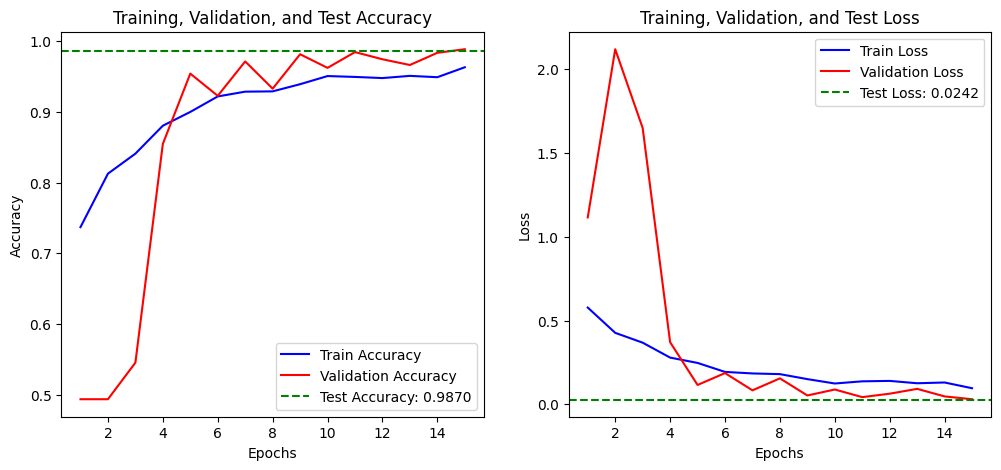

In [29]:
import matplotlib.pyplot as plt

# Extract accuracy and loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_acc) + 1)

# Plot Training, Validation, and Test Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, 'b', label='Train Accuracy')  # Blue
plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')  # Red
plt.axhline(y=test_acc, color='g', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')  # Blue Dashed
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

# Plot Training, Validation, and Test Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, 'b', label='Train Loss')  # Blue
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')  # Red
plt.axhline(y=test_loss, color='g', linestyle='--', label=f'Test Loss: {test_loss:.4f}')  # Blue Dashed
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

plt.show()


In [10]:
from sklearn.metrics import classification_report
import numpy as np

# Get True Labels
y_true = test_generator.classes

# Get Predicted Probabilities
y_pred_probs = model.predict(test_generator)

# Convert Probabilities to Binary Labels
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Get Class Names
class_names = list(test_generator.class_indices.keys())

# Generate Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step
                 precision    recall  f1-score   support

bleached_corals       0.99      0.98      0.99       485
 healthy_corals       0.98      0.99      0.99       438

       accuracy                           0.99       923
      macro avg       0.99      0.99      0.99       923
   weighted avg       0.99      0.99      0.99       923



In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Define class labels (Update according to your dataset)
class_labels = ['Healthy', 'Bleached']  # Change as per your dataset

# Load and preprocess a single image
img_path = "/kaggle/input/coralreef/Bleached Corals and Healthy Corals Classification/Training/bleached_corals/10033870215_3664757d59_o_0_9189_0_1694.jpg"  # Change this to your test image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch format
img_array = img_array / 255.0  # Normalize (if needed)

# Make prediction using the trained model in memory
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get class index

# Print the result
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Confidence Scores: {predictions[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class: Healthy
Confidence Scores: [5.702315e-06]
